In [1]:
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from matplotlib.ticker import MaxNLocator
from statsmodels.stats.multitest import multipletests
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.10.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.2
ipykernel        

# **Table of contents**:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

## **1. Parse Gene Core ontology (OBO Format)**

This is the basic version of the GO, filtered such that the graph is guaranteed to be acyclic and annotations can be propagated up the graph. The relations included are is a, part of, regulates, negatively regulates and positively regulates. This version excludes relationships that cross the 3 GO hierarchies.

The parsing is done with [**goscripts**](https://pmoris.github.io/goscripts/_build/html/source/README.html), a python script and package for Gene Ontology enrichment analysis.

In [4]:
from goscripts.goscripts.obo_tools import importOBO, completeChildHierarchy, buildGOtree

In [5]:
GOdict = importOBO('../data/pathway_databases/go_terms.obo', ignore_part_of=True)
# Generate the entire GO tree’s parent structure by walking through the hierarchy of each GO entry

Retrieved 47497 GO terms from /Users/temitopeleke/Documents/Research Documents/Research codes/mathys_reproduce/data/pathway_databases/go_terms.obo 

Adding secondary GO identifiers...



Next we build the entire GO tree parent and child structure for only `Biological Processes with GO ID GO:0008150` by walking through the hierarchy of each GO entry using `buildGOtree` and setting the `root_node = ['GO:0008150']`.

This function assigns all higher order ancestors (recursive parents) for each GO object, assigns immediate children, assigns all recursively found children, assign depth to each node.

In [6]:
# here we set the root node as "Biological Processes with GO ID GO:0008150"
buildGOtree(GOdict, root_nodes=['GO:0008150']) 
#completeChildHierarchy(GOdict) # Generates the entire GO tree’s child structure.

## **2. Reading in the data**

We load the preprocessed and annotated pathway differential scores across the following tests:

- `AD vs no-AD`
- `Late vs Early`
- `Early vs no-AD`
- `Late vs no-AD`


In [7]:
# load all pathways
pathway_scores = {}
cell_types = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC",]
studies = ['allen_mtg', 'leng_etc', 'leng_sfg']
tests = ['early_vs_no', 'late_vs_early', 'ad_vs_no', 'late_vs_no']
for study in studies:
    pathway_scores[study] = {}
    for test in tests:
        pathway_scores[study][test] = pd.read_csv(f'../results/{test}/{study}_differentially_expressed_pathways.csv')
        pathway_scores[study][test]['shortened'] = pathway_scores[study][test]['pathway']

### **Get parent GO name at a certain node**

In [8]:
def get_parent_at_depth(goid, depth):
    
    """
    Given a Gene Ontology (GO) term ID and a desired depth in the GO hierarchy, this function returns the name of the
    first parent GO term at that depth.

    Parameters:
    -----------
    - goid (str): A string representing the GO term ID.
    - depth (int): An integer representing the desired depth in the GO hierarchy.

    Returns:
    --------
    - str: The name of the parent GO term at the desired depth in the GO hierarchy.

    """
        
    for parent in GOdict.get(goid).recursive_parents:
        if GOdict.get(parent).depth == depth:
            return GOdict.get(parent).name
        else:
            continue

### **Overall Overlap**

Load overlapping pathways saved to `f'../results/{test_name}/{test_name}_pathway_overlap.csv'` from previous analysis

In [9]:
go_node_depths = [1, 2, 3, 4, 5, 6, 7, 8]
overlap_paths = {}

for test_name in tests:
    overlap_paths[test_name] = pd.read_csv(f'../results/{test_name}/{test_name}_pathway_overlap.csv')

Save to pathway names to R

In [10]:

try:
    list_of_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_paths[test_name].pathway.to_list()) for test_name in tests})
except AttributeError:
    temp_tests = []
    for test_name in test:
        if len(overlap_paths.pathway)>0:
            temp_tests.append(test_name)
        else:
            print(f"AttributeError occurred for test_name: {test_name}")
    list_of_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_paths[test_name].pathway.to_list()) for test_name in temp_tests})


#### **Load DEGs** 

In [11]:
degs = {}
merged_degs = {}
celltypes = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"]
deg_methods =  ['edgeR-QLF', 'DESeq2-Wald', 'limma-voom']


for study in studies:

    degs[study] = {}
    merged_degs[study] = {}

    for test in tests:
      
        degs[study][test] = {}
        merged_degs[study][test] = {}

        for method in deg_methods:
         
            degs[study][test][method] = {}
            merged_degs[study][test][method] = {}
            merged_df = pd.DataFrame(columns=['gene'])

            for cell_type in celltypes:
                degs[study][test][method][cell_type] = pd.read_excel(f'../results/{test}/{study}_{method}_degs.xlsx', 
                                                                            sheet_name=cell_type,)
                
                df = degs[study][test][method][cell_type]
                df = df.rename(columns={'avg_logFC': f'{cell_type}_logFC', 'p_val_adj': f'{cell_type}_Pvalue'})
                merged_df = pd.merge(merged_df, df[['gene', f'{cell_type}_logFC', f'{cell_type}_Pvalue']], on='gene', how='outer')
        
            merged_degs[study][test][method]['logFC'] = merged_df[['gene'] + list(merged_df.filter(like='logFC').columns)]
            merged_degs[study][test][method]['Pvals'] = merged_df[['gene'] + list(merged_df.filter(like='Pvalue').columns)]



# convert nested dataframe into Rpy2 object 

all_degs =  robjects.ListVector(
                        {
                            study: robjects.ListVector(
                                {
                                    test_name: robjects.ListVector(
                                        {
                                            method: robjects.ListVector(
    
                                                {stat: pandas2ri.py2rpy(merged_degs[study][test_name][method][stat])
                                                 
                                                    for stat in ['logFC', 'Pvals']
                                                }
                                            )
                                            for method in deg_methods
                                        }
                                    )
                                    for test_name in tests
                                }
                            )
                            for study in studies
                        }
                    )


#### **Load Genes In Each Pathway** 

In the **`../scripts/pathway_analysis.ipynb`** notebook, we have preprocessed the pathways and filtered genes that do not meet a certain threshold (typically **`<5%`** in a cell-type) in each of the the studies.

These filtered pathways were saved to **`../results/gsva/{study_name}/{cell_type}`**.

We next visualize the expression pattern of these genes using the circular heatmap


In [12]:
%%R -o overlap_degs_broad -o overlap_degs_celltype -o geneSets -i studies -i tests -i celltypes -i list_of_overlapping_paths -i all_degs -i deg_methods


library(EnhancedVolcano)
library(circlize)
library(GSEABase)
library(GSVA) 
library(ComplexHeatmap)



color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'



# iterate over celltypes and obtain 
geneSets <- list()
for(test_name in tests){

  geneSets[[test_name]] <- list()
  for (study in studies){

    geneSets[[test_name]][[study]] <- list()
    for (cur_celltype in celltypes){
        # get gene sets
        geneSets[[test_name]][[study]][[cur_celltype]] <- getGmt(file.path('../results/gsva/', study, '/', cur_celltype, 'gs.gmt'))
        geneSets[[test_name]][[study]][[cur_celltype]] <- geneIds(geneSets[[test_name]][[study]][[cur_celltype]])

        # Check if test_name exists in list_of_overlapping_paths
        if (test_name %in% names(list_of_overlapping_paths)) {
          geneSets[[test_name]][[study]][[cur_celltype]] <-  geneSets[[test_name]][[study]][[cur_celltype]][names(geneSets[[test_name]][[study]][[cur_celltype]]) %in% list_of_overlapping_paths[[test_name]]]
          } else {
          geneSets[[test_name]][[study]][[cur_celltype]] <- character(0)  # Set an empty vector if no scores exist
        }
        geneSets[[test_name]][[study]][[cur_celltype]] <- unlist(geneSets[[test_name]][[study]][[cur_celltype]], recursive = FALSE)
    }
    geneSets[[test_name]][[study]] <- unique(unlist(geneSets[[test_name]][[study]], recursive = FALSE))
  }
}

overlap_degs_broad <- list()
overlap_degs_celltype <- list()

for (study in studies){

  overlap_degs_broad[[study]] <- list()
  overlap_degs_celltype[[study]] <- list()

  for (test_name in tests){

    overlap_degs_broad[[study]][[test_name]] <- list()
    overlap_degs_celltype[[study]][[test_name]] <- list()

    if (test_name %in% names(list_of_overlapping_paths)) {
      
      for (method in deg_methods){

        # for (stat in c('logFC', 'Pvals')){   
        logfc = subset(all_degs[[study]][[test_name]][[method]][['logFC']], gene %in% geneSets[[test_name]][[study]])
        pvals = subset(all_degs[[study]][[test_name]][[method]][['Pvals']], gene %in% geneSets[[test_name]][[study]])

        rownames(logfc) <- logfc[, "gene"]
        rownames(pvals) <- pvals[, "gene"]

        logfc[is.na(logfc)] <- 0
        pvals[is.na(pvals)] <- 1

        logfc <- logfc[, -which(colnames(logfc) == "gene")]
        pvals <- -log10(pvals[, -which(colnames(pvals) == "gene")])

        overlap_degs_broad[[study]][[test_name]][[method]] <- 
          as.vector(intersect(
            rownames(logfc[unname(rowSums(abs(logfc)>0.25)>=1),] ),
            rownames(pvals[unname(rowSums(abs(pvals)>2)>=1),])))

        print(paste0('There are ', length(overlap_degs_broad[[study]][[test_name]][[method]]), 
                    " DEGs in at least one cell-type in: ",
                     toupper(study), ' ', 
                     toupper(test_name), ' test using ', 
                     toupper(method), ' method'))


        overlap_degs_celltype[[study]][[test_name]][[method]] <- list()

        for (cur_celltype in celltypes) {
          overlap_degs_celltype[[study]][[test_name]][[method]][[cur_celltype]] <- 
            as.vector(intersect(
              rownames(logfc[abs(logfc[paste0(cur_celltype, "_logFC")]) > 0.25,]),
              rownames(pvals[abs(pvals[paste0(cur_celltype, "_Pvalue")]) > 2, ])
            ))
          
          # Save the result to a CSV file
          write.csv(overlap_degs_celltype[[study]][[test_name]][[method]][[cur_celltype]],
                  file = paste0("../results/", test_name, '/',
                          study, '_', method, '_', cur_celltype, "_DEGs_in_overlapping_pathways.csv"), 
                  row.names = FALSE, col.names='gene')
        }
      } 
    } 

  print("..................")

  }
  print(" ")
  print("........................................................")
  print(" ")  
}



[1] "There are 0 DEGs in at least one cell-type in: ALLEN_MTG EARLY_VS_NO test using EDGER-QLF method"
[1] "There are 210 DEGs in at least one cell-type in: ALLEN_MTG EARLY_VS_NO test using DESEQ2-WALD method"
[1] "There are 0 DEGs in at least one cell-type in: ALLEN_MTG EARLY_VS_NO test using LIMMA-VOOM method"
[1] ".................."
[1] "There are 0 DEGs in at least one cell-type in: ALLEN_MTG LATE_VS_EARLY test using EDGER-QLF method"
[1] "There are 38 DEGs in at least one cell-type in: ALLEN_MTG LATE_VS_EARLY test using DESEQ2-WALD method"
[1] "There are 0 DEGs in at least one cell-type in: ALLEN_MTG LATE_VS_EARLY test using LIMMA-VOOM method"
[1] ".................."
[1] "There are 126 DEGs in at least one cell-type in: ALLEN_MTG AD_VS_NO test using EDGER-QLF method"
[1] "There are 978 DEGs in at least one cell-type in: ALLEN_MTG AD_VS_NO test using DESEQ2-WALD method"
[1] "There are 0 DEGs in at least one cell-type in: ALLEN_MTG AD_VS_NO test using LIMMA-VOOM method"
[1] ".....

In [13]:
bp = pathway_analyses.read_pathways('../data/pathway_databases/GO_Biological_Process_2018.txt')
go_bp_paths = bp.set_index(0)
go_bp_paths.fillna("", inplace=True)
go_bp_paths_dict = go_bp_paths.to_dict(orient='index')

path_by_gene = {key: [val for val in value.values() if val != ""] for key, value in go_bp_paths_dict.items()}
path_by_gene = pd.DataFrame.from_dict(path_by_gene, orient='index').transpose()

gene_by_path = pd.DataFrame.from_dict(path_by_gene.to_dict(), orient='index').T
gene_by_path = gene_by_path.melt(var_name='pathway', value_name='gene')
gene_by_path = gene_by_path.dropna()
gene_by_path = gene_by_path.groupby('gene')['pathway'].apply(list).reset_index()
gene_by_path['count'] = gene_by_path.pathway.apply(lambda x: len(x))
gene_by_path.sort_values(by='count', inplace=True, ascending=False)

/Users/temitopeleke/Documents/Research Documents/Research codes/mathys_reproduce/scripts/functions/pathway_analyses.py:225: DtypeWarning: Columns (488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,7

In [14]:
broad_deg_overlap = {}
cell_type_deg_overlap = {}

for test_name in tests:
    broad_deg_overlap[test_name] = {}
    cell_type_deg_overlap[test_name] = {}
    overlap_pathways = pd.read_csv(f'../results/{test_name}/{test_name}_pathway_overlap.csv')

    for method in deg_methods:
        eval_string = []
        for i, study in enumerate(pathway_scores.keys()):
            eval_string.append(f'set(overlap_degs_broad["{study}"]["{test_name}"]["{method}"])')

        eval_string = '&'.join(eval_string)
        eval_list = list(eval(eval_string))
        broad_deg_overlap[test_name][method] = pd.DataFrame({'genes': eval_list})
        broad_deg_overlap[test_name][method]['pathway'] = broad_deg_overlap[test_name][method]['genes'].map(dict(zip(gene_by_path['gene'], gene_by_path['pathway'])),
                                                                                                            na_action='ignore')
        # broad_deg_overlap[test_name][method]['count'] = broad_deg_overlap[test_name][method]['genes'].map(dict(zip(gene_by_path['gene'], gene_by_path['count'])),
        #                                                                                                    na_action='ignore')
        
        broad_deg_overlap[test_name][method] = broad_deg_overlap[test_name][method].explode('pathway')
        broad_deg_overlap[test_name][method] = broad_deg_overlap[test_name][method][broad_deg_overlap[test_name][method].pathway.isin(overlap_pathways.pathway)]
        broad_deg_overlap[test_name][method]['count'] = broad_deg_overlap[test_name][method].genes.map(broad_deg_overlap[test_name][method].value_counts('genes').to_dict())
        broad_deg_overlap[test_name][method].sort_values(by='genes', inplace=True)
        broad_deg_overlap[test_name][method].sort_values(by='count', inplace=True, ascending=False)
        broad_deg_overlap[test_name][method].reset_index(inplace=True, drop=True)
        broad_deg_overlap[test_name][method].to_csv(f'../results/{test_name}/gene_by_pathway_overlap_broad_{method}.csv')
        
        cell_type_deg_overlap[test_name][method] = {}

        for cell_type in cell_types:
            eval_string = []
            for i, study in enumerate(pathway_scores.keys()):
                eval_string.append(f'set(overlap_degs_celltype["{study}"]["{test_name}"]["{method}"]["{cell_type}"])')
            
            eval_string = '&'.join(eval_string)
            eval_list = list(eval(eval_string))
            #cell_type_deg_overlap[test_name][method][cell_type] = pd.DataFrame({'gene': eval_list})   
            cell_type_deg_overlap[test_name][method][cell_type] = eval_list

        cell_type_deg_overlap[test_name][method] = pd.DataFrame({key: pd.Series(lst) \
                                                                 for key, lst in cell_type_deg_overlap[test_name][method].items()})
        
        #cell_type_deg_overlap[test_name][method].sort_values(by=cell_types, inplace=True)
        cell_type_deg_overlap[test_name][method].reset_index(inplace=True, drop=True)
        cell_type_deg_overlap[test_name][method].replace(np.nan, 0, inplace=True)
        
        df = cell_type_deg_overlap[test_name][method].to_dict('list')

        with pd.ExcelWriter(f"../results/{test_name}/gene_by_pathway_overlap_celltype_{method}.xlsx") as writer:
            for cell_type in celltypes:
                data = pd.DataFrame({'genes': df[cell_type]})
                data['pathway'] = data["genes"].map(dict(zip(gene_by_path['gene'], gene_by_path['pathway'])), na_action='ignore')
                data = data.explode('pathway')
                data = data[data.pathway.isin(overlap_pathways.pathway)]
                data['count'] = data.genes.map(data.value_counts('genes').to_dict())
                data.sort_values(by='genes', inplace=True)
                data.sort_values(by='count', inplace=True, ascending=False)
                data.reset_index(inplace=True, drop=True)
                data.to_excel(writer, sheet_name=cell_type, na_rep='NA')

        # cell_type_deg_overlap[test_name][method].to_csv(f'../results/{test_name}/gene_by_pathway_overlap_celltype_{method}.csv')

### **Venn Diagrams showing number of overlapping genes in the overlapping pathways across all studiess in each cell type**

This code generates Venn diagrams that show the number of overlapping genes in the overlapping pathways across all studies in each cell type. The code reads in gene and pathways data from multiple studies and creates a Venn diagram for each cell type. The Venn diagram is generated using the matplotlib-venn library. 

The gene data is first processed to obtain a set of genes for each cell type. Then, the sets are combined to create a master set of genes that includes all genes across all cell types. The number of genes that are unique to each cell type and the number of genes that are shared between cell types are determined using set operations. The resulting values are then used to generate the Venn diagrams.

The code uses a loop to iterate through each cell type and generate a Venn diagram for that cell type. The Venn diagrams are saved to disk as PNG files.


In [15]:
%%R -i studies -i tests -i celltypes -i all_degs -i deg_methods

library(VennDiagram)
library(gridExtra)
library(Seurat)
library(Signac)
library(tidyverse)
library(future.apply)
library(ggpubr)
library(reshape2)
library(tictoc)
library(patchwork)
library(ggridges)
library(RColorBrewer)
library(eulerr)
library(GeneOverlap)


# iterate over celltypes and obtain 
geneSets <- list()
for(test_name in tests){

  geneSets[[test_name]] <- list()
  for (study in studies){

    geneSets[[test_name]][[study]] <- list()
    for (cur_celltype in celltypes){
        # get gene sets
        geneSets[[test_name]][[study]][[cur_celltype]] <- getGmt(file.path('../results/gsva/', study, '/', cur_celltype, 'gs.gmt'))
        geneSets[[test_name]][[study]][[cur_celltype]] <- geneIds(geneSets[[test_name]][[study]][[cur_celltype]])

        # Check if test_name exists in list_of_overlapping_paths
        if (test_name %in% names(list_of_overlapping_paths)) {
          geneSets[[test_name]][[study]][[cur_celltype]] <-  geneSets[[test_name]][[study]][[cur_celltype]][names(geneSets[[test_name]][[study]][[cur_celltype]]) %in% list_of_overlapping_paths[[test_name]]]
          } else {
          geneSets[[test_name]][[study]][[cur_celltype]] <- character(0)  # Set an empty vector if no scores exist
        }
        geneSets[[test_name]][[study]][[cur_celltype]] <- unlist(geneSets[[test_name]][[study]][[cur_celltype]], recursive = FALSE)
    }
    geneSets[[test_name]][[study]] <- unlist(geneSets[[test_name]][[study]], recursive = FALSE)
  }
}



# load all pathways
degs_celltype <- list()

# Loop over each study in a vector of studies
for (study in studies) {
  # Create an empty list to hold pathway scores for the current study
  degs_celltype[[study]] <- list()
  
  # Loop over each test in a vector of tests
  for (test_name in tests) {

    if (test_name %in% list_of_overlapping_paths){

      degs_celltype[[study]][[test_name]] <- list()

      for (method in deg_methods){
        # Filter the DEGs
        
        # for (stat in c('logFC', 'Pvals')){   
        logfc = subset(all_degs[[study]][[test_name]][[method]][['logFC']], gene %in% geneSets[[test_name]][[study]])
        pvals = subset(all_degs[[study]][[test_name]][[method]][['Pvals']], gene %in% geneSets[[test_name]][[study]])

        rownames(logfc) <- logfc[, "gene"]
        rownames(pvals) <- pvals[, "gene"]

        logfc[is.na(logfc)] <- 0
        pvals[is.na(pvals)] <- 1

        logfc <- logfc[, -which(colnames(logfc) == "gene")]
        pvals <- -log10(pvals[, -which(colnames(pvals) == "gene")])

        degs_celltype[[study]][[test_name]][[method]] <- list()

        for (cur_celltype in celltypes) {
          degs_celltype[[study]][[test_name]][[method]][[cur_celltype]] <- 
            as.vector(intersect(
              rownames(logfc[abs(logfc[paste0(cur_celltype, "_logFC")]) > 0.25,]),
              rownames(pvals[abs(pvals[paste0(cur_celltype, "_Pvalue")]) > 2, ])
            ))
        }
      }
    }
  }
}

# create a list of unique cell types

# Upset plot to show how many target genes are shared & how many are cell type specific

fisher_df <- data.frame()
color_scheme_celltype <- list()
color_scheme_celltype[['Excitatory']] = 'aquamarine3'
color_scheme_celltype[['Inhibitory']] = 'darkolivegreen3'
color_scheme_celltype[['Astrocyte']] = 'brown3'
color_scheme_celltype[['Oligodendrocyte']] = 'darkorchid3'
color_scheme_celltype[['Microglia']] = 'deepskyblue3'
color_scheme_celltype[['OPC']] = 'deeppink3'
  


for(test_name in tests){

  if (test_name %in% list_of_overlapping_paths){

    for (method in deg_methods){
      
      for(cur_celltype in celltypes){
        
          # get diagnosis DEGs for this celltype:
          # cur_degs <- celltype.diagnosis.markers %>% subset(cluster == 'AD' & celltype ==  cur_celltype & avg_logFC >= 0)
        
          # get celltype degs for this celltype:

          cur_celltype_genes_mtg <- degs_celltype[['allen_mtg']][[test_name]][[method]][[cur_celltype]]
          cur_celltype_genes_etc <- degs_celltype[['leng_etc']][[test_name]][[method]][[cur_celltype]]
          cur_celltype_genes_sfg <- degs_celltype[['leng_sfg']][[test_name]][[method]][[cur_celltype]]
        
          # overlap between links and diagnosis degs
          # diag_overlap_pval <- testGeneOverlap(newGeneOverlap(
          #   unique(cur_celltype_pathways_mtg$pathway),
          #   unique(cur_celltype_pathways_etc$pathway),
          #   genome.size=length(intersect(rownames(NucSeq), proj@peakSet$nearestGene))
          # ))@pval
        
          # celltype_overlap_pval <- testGeneOverlap(newGeneOverlap(
          #   cur_celltype_degs$gene,
          #   unique(cur_links$Peak1_nearestGene),
          #   genome.size=length(intersect(rownames(NucSeq), proj@peakSet$nearestGene))
          # ))@pval
          # 
          
          # update fisher df:
          # diag_df <- data.frame(pval = diag_overlap_pval, celltype=cur_celltype, type='diagnosis')
          # celltype_df <- data.frame(pval = celltype_overlap_pval, celltype=cur_celltype, type='celltype')
        
          # fisher_df <- Reduce(rbind, list(fisher_df, diag_df, celltype_df))
        
          # set up relevant lists:
          gene_set_list <- list(
            'MTG' = as.character(cur_celltype_genes_mtg),
            'ETC' = as.character(cur_celltype_genes_etc),
            'SFG' = as.character(cur_celltype_genes_sfg)
          )
        
          venn_list <- list()
          for(i in 1:length(gene_set_list)){
            cur_genes <- gene_set_list[[i]]
        
            other_indices <- (i:length(gene_set_list))[i:length(gene_set_list) != i]
        
            # number of pathways in cur set and not other sets:
            venn_list[[names(gene_set_list)[i]]] <- sum(!(cur_genes %in% Reduce(union, gene_set_list[other_indices])))
        
        
            for(j in other_indices){
              other_genes <- gene_set_list[[j]]
              venn_list[[paste0(names(gene_set_list)[i],'&',names(gene_set_list)[j])]] <- length(intersect(cur_genes, other_genes))
            }
          }
        
          # number of pathways in common between all sets:
          venn_list[[paste0(names(gene_set_list)[1], '&', names(gene_set_list)[2], '&', names(gene_set_list)[3])]] <- length(Reduce(intersect, gene_set_list))
        
          

          VennDiag <- euler(unlist(venn_list))
          svg(paste0('../results/', test_name, '/venn_DEGs_', method, '_', cur_celltype,'.svg'), width=6, height=6)
      
          print(plot(
            VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
            fill=rep(color_scheme_celltype[[cur_celltype]], 3)
          ))
          dev.off()

          pdf(paste0('../results/', test_name, '/venn_DEGs_', method, '_', cur_celltype, '.pdf'), width=6, height=6)  
          print(plot(
            VennDiag, quantities=TRUE, counts = TRUE, font=5, cex=1, alpha=0.8,
            fill=rep(color_scheme_celltype[[cur_celltype]], 3)
          ))
          dev.off()

      }
    }
  }
}

  # # add significance stars:
  # fisher_df$significance <- stars.pval(fisher_df$pval)
  # 
  # fisher_df$significance <- ifelse(
  #   fisher_df$pval > 0.05, 'n.s.', ifelse(
  #   fisher_df$pval >= 0.05, '*', ifelse(
  #   fisher_df$pval >= 0.005, '**', '***'
  # )))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%()    masks IRanges::%within%()
✖ BiocGenerics::Position() masks ggplot2::Position(), base::Position()
✖ stringr::boundary()      masks graph::boundary()
✖ dplyr::collapse()        masks IRanges::collapse()
✖ dplyr::combine()         masks gridExtra::combine(), Biobase::combine(), BiocGenerics::combine()
✖ dplyr::desc()            masks IRanges::desc()
✖ tidyr::expand()          masks S4Vectors::expand()
✖ dplyr::filter()          masks stats::filter()
✖ dply

## **Plot Enrichment Result obtained from STRING**

In [16]:
# # Scatter Plot Parameters
# significance_value = 0.05


# # Bar Chart Functions
# # Takes all terms, all p-values, all adjusted p-values, plot title, Enrichr libraries, and specified figure format
# def enrichment_figure(all_terms, all_pvalues, all_adjusted_pvalues, plot_names, all_libraries, bar_color): 
#     # Bar colors
#     if bar_color != 'lightgrey':
#         bar_color_not_sig = 'lightgrey'
#         edgecolor=None
#         linewidth=0
#     else:
#         bar_color_not_sig = 'white'
#         edgecolor='black'
#         linewidth=1    

#     plt.figure(figsize=(24, 12))
    
#     i = 0
#     bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues]
#     fig = sb.barplot(x=np.log10(all_pvalues)*-1, y=all_terms, palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth,)
#     fig.axes.get_yaxis().set_visible(False)
#     fig.set_title(all_libraries[i].replace('_', ' '), fontsize=26)
#     fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
#     fig.xaxis.set_major_locator(MaxNLocator(integer=True))
#     fig.tick_params(axis='x', which='major', labelsize=20)
#     if max(np.log10(all_pvalues)*-1)<1:
#         fig.xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues)*-1), 0.1))
#     for ii, annot in enumerate(all_terms):
#         # if all_adjusted_pvalues[ii] < 0.05:
#         #     annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[ii], precision=2)))]) 
#         # else:
#         #     annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[ii], precision=2)))])

#         title_start= max(fig.axes.get_xlim())/200
#         fig.text(title_start, ii, annot, ha='left', wrap = True, fontsize = 26)

#     fig.spines['right'].set_visible(False)
#     fig.spines['top'].set_visible(False)

#     for plot_name in plot_names:
#         plt.savefig(plot_name, bbox_inches = 'tight')
    
#     # Show plot 
#     plt.show()

Enrichment Terms in EXCITATORY


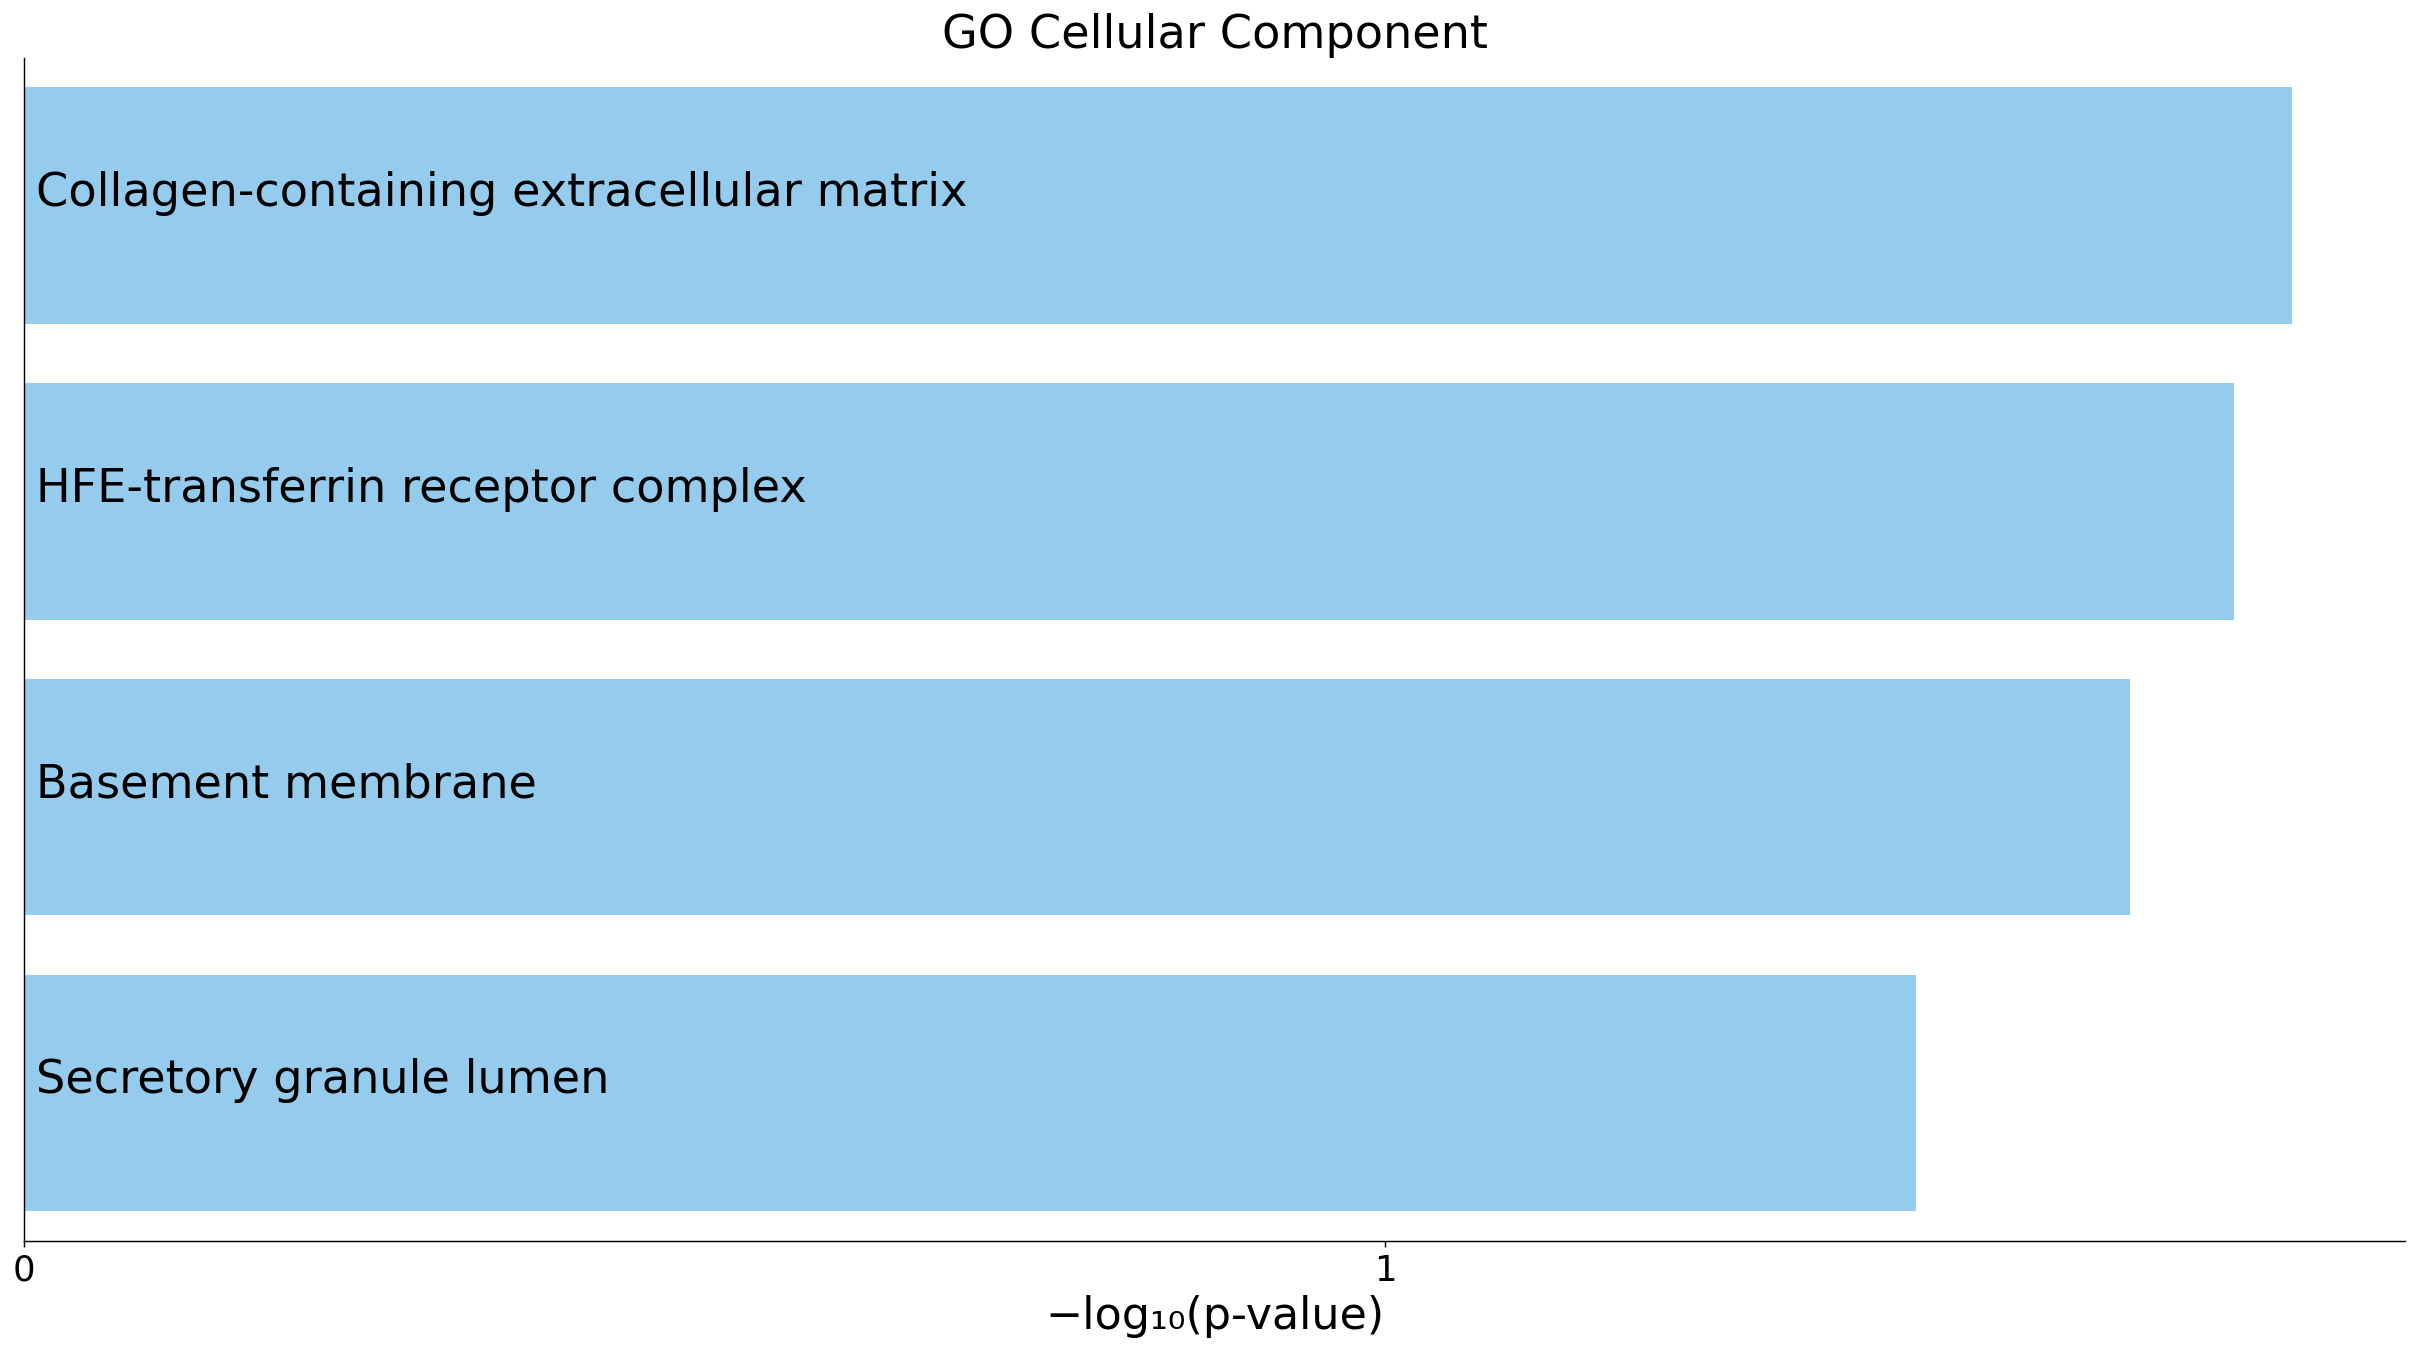

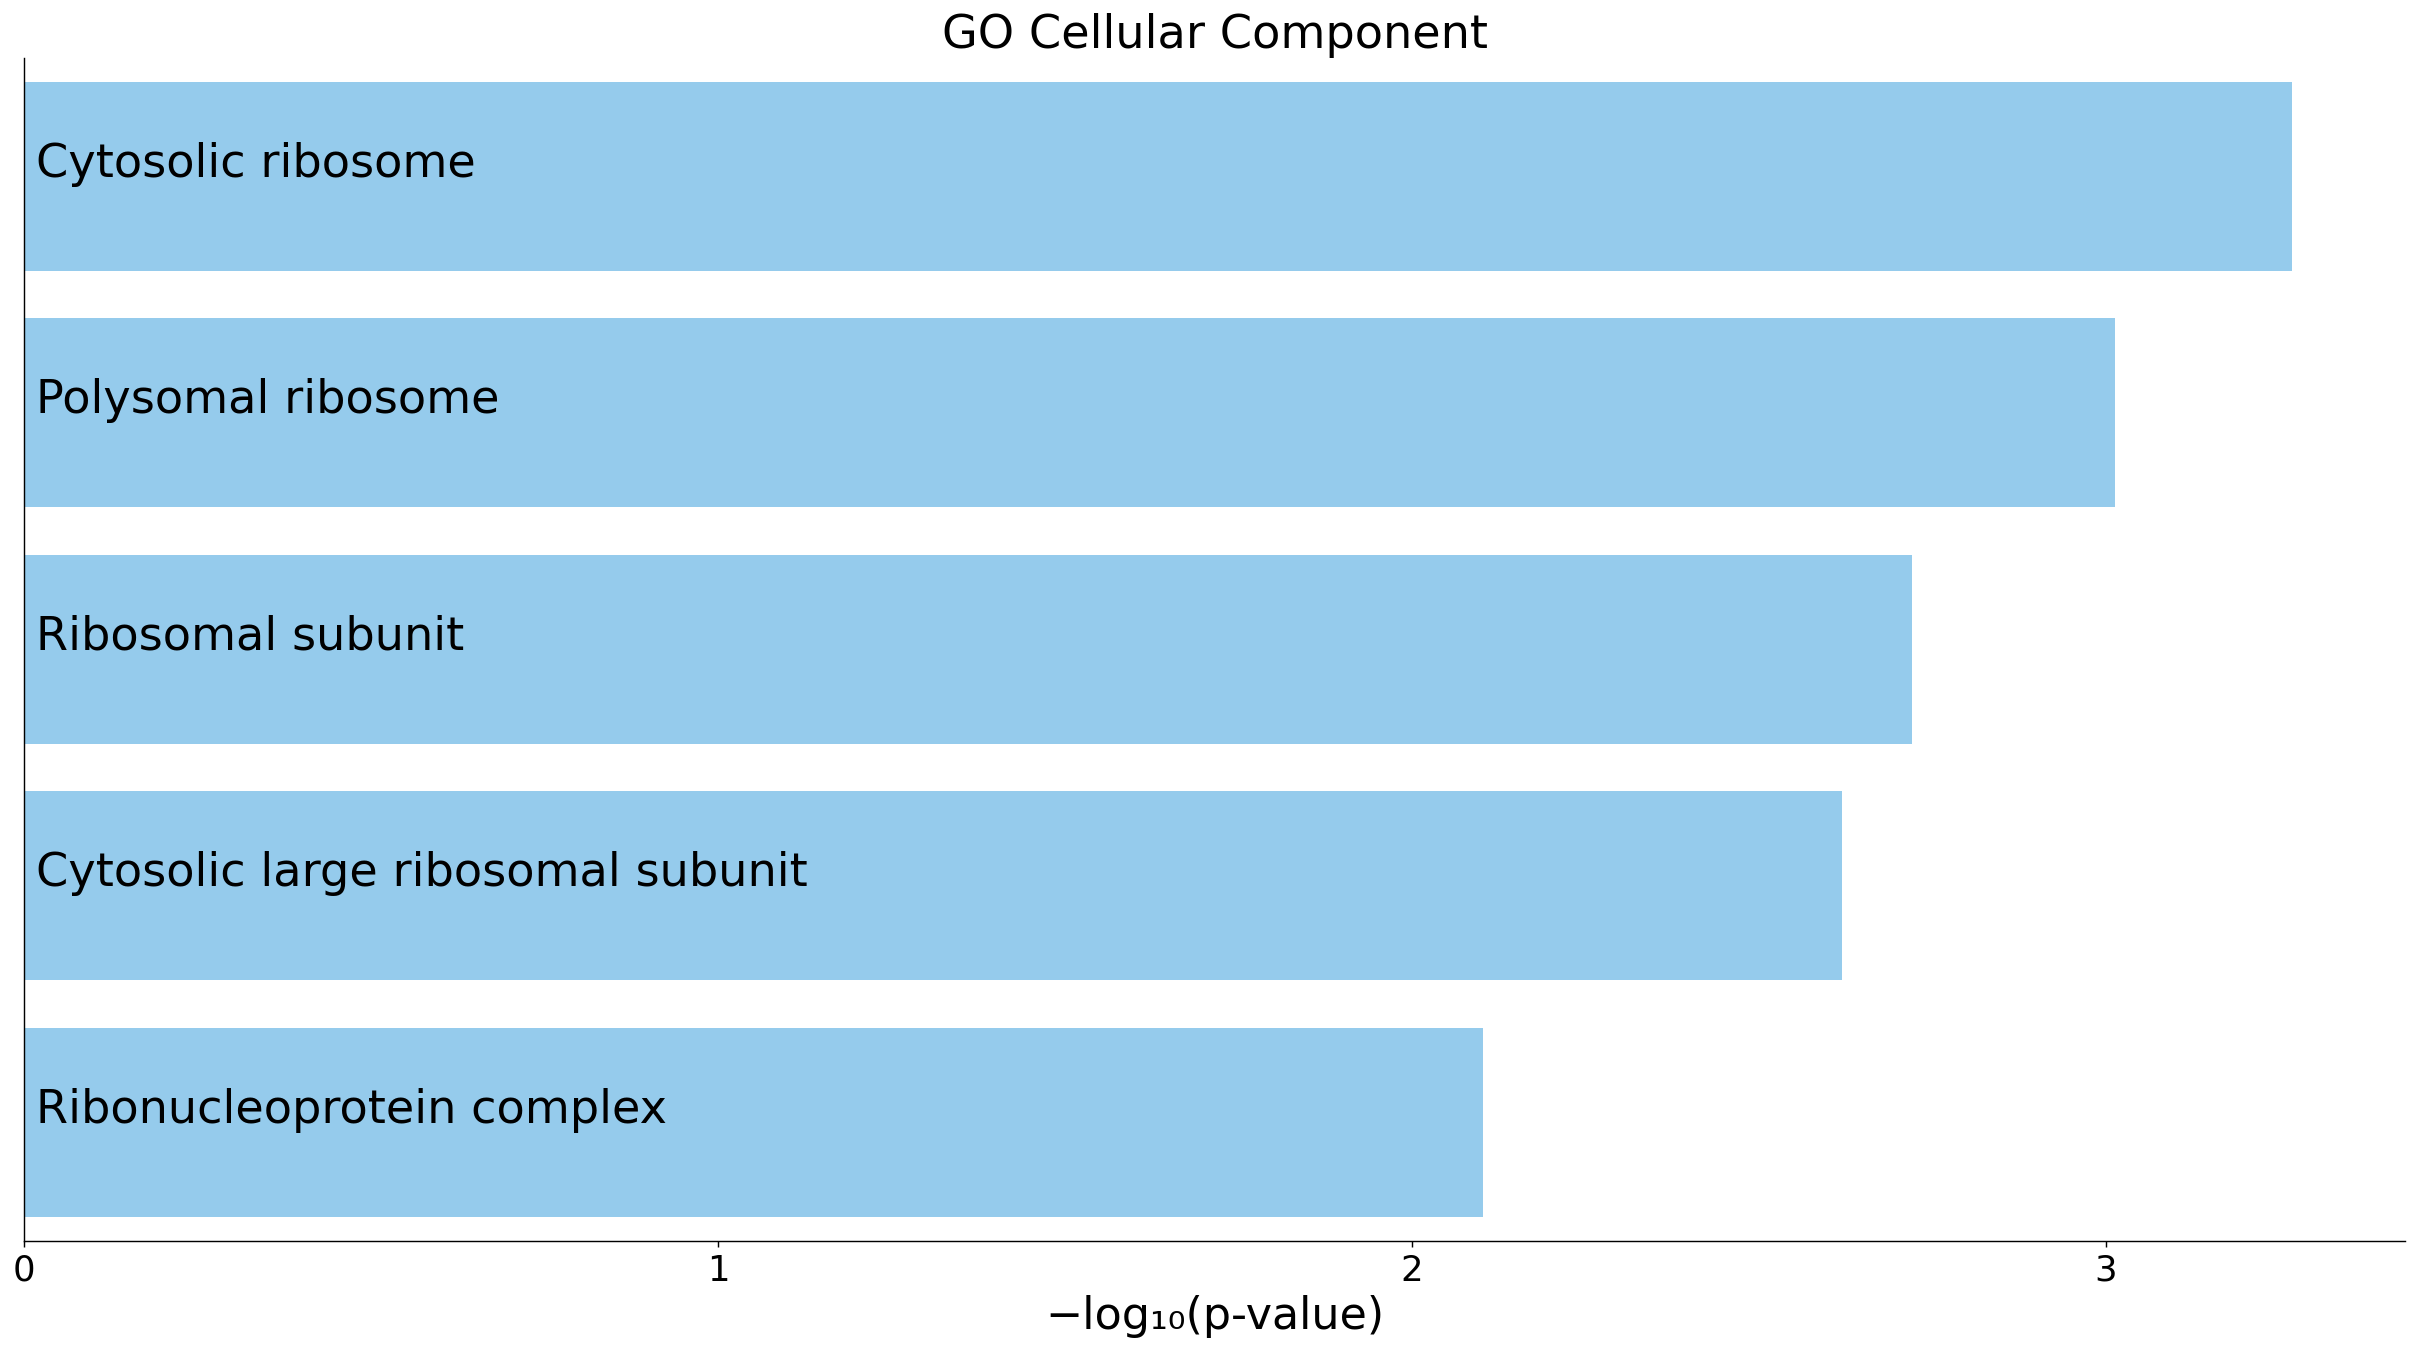

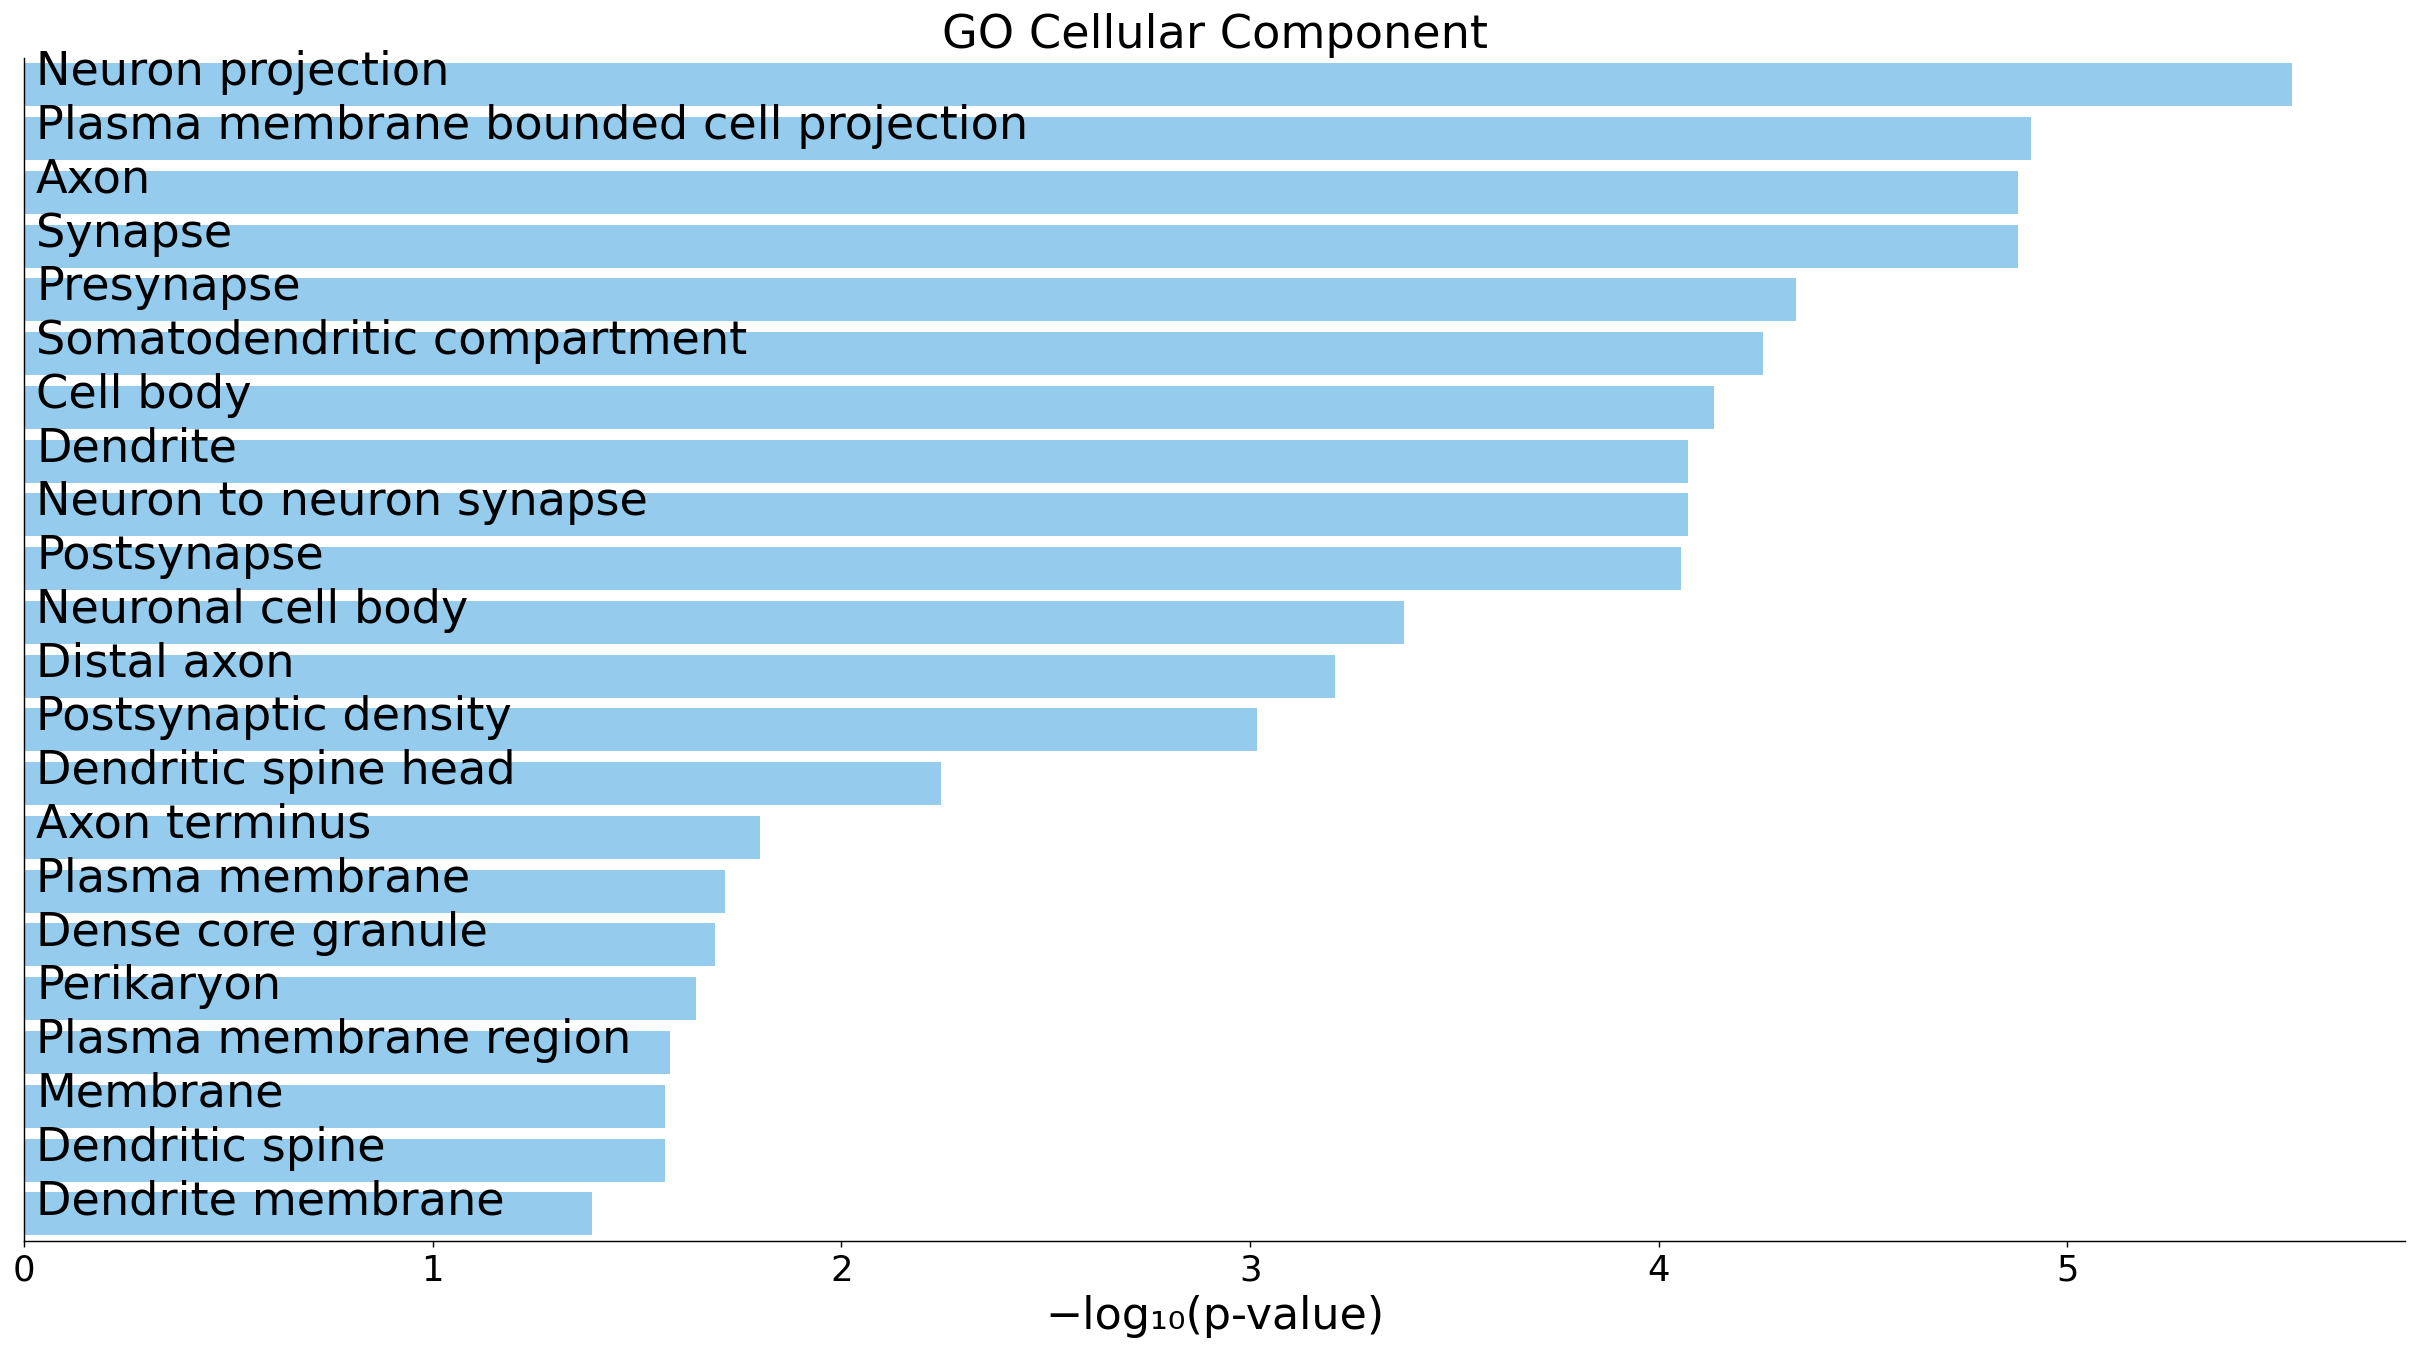

Enrichment Terms in INHIBITORY


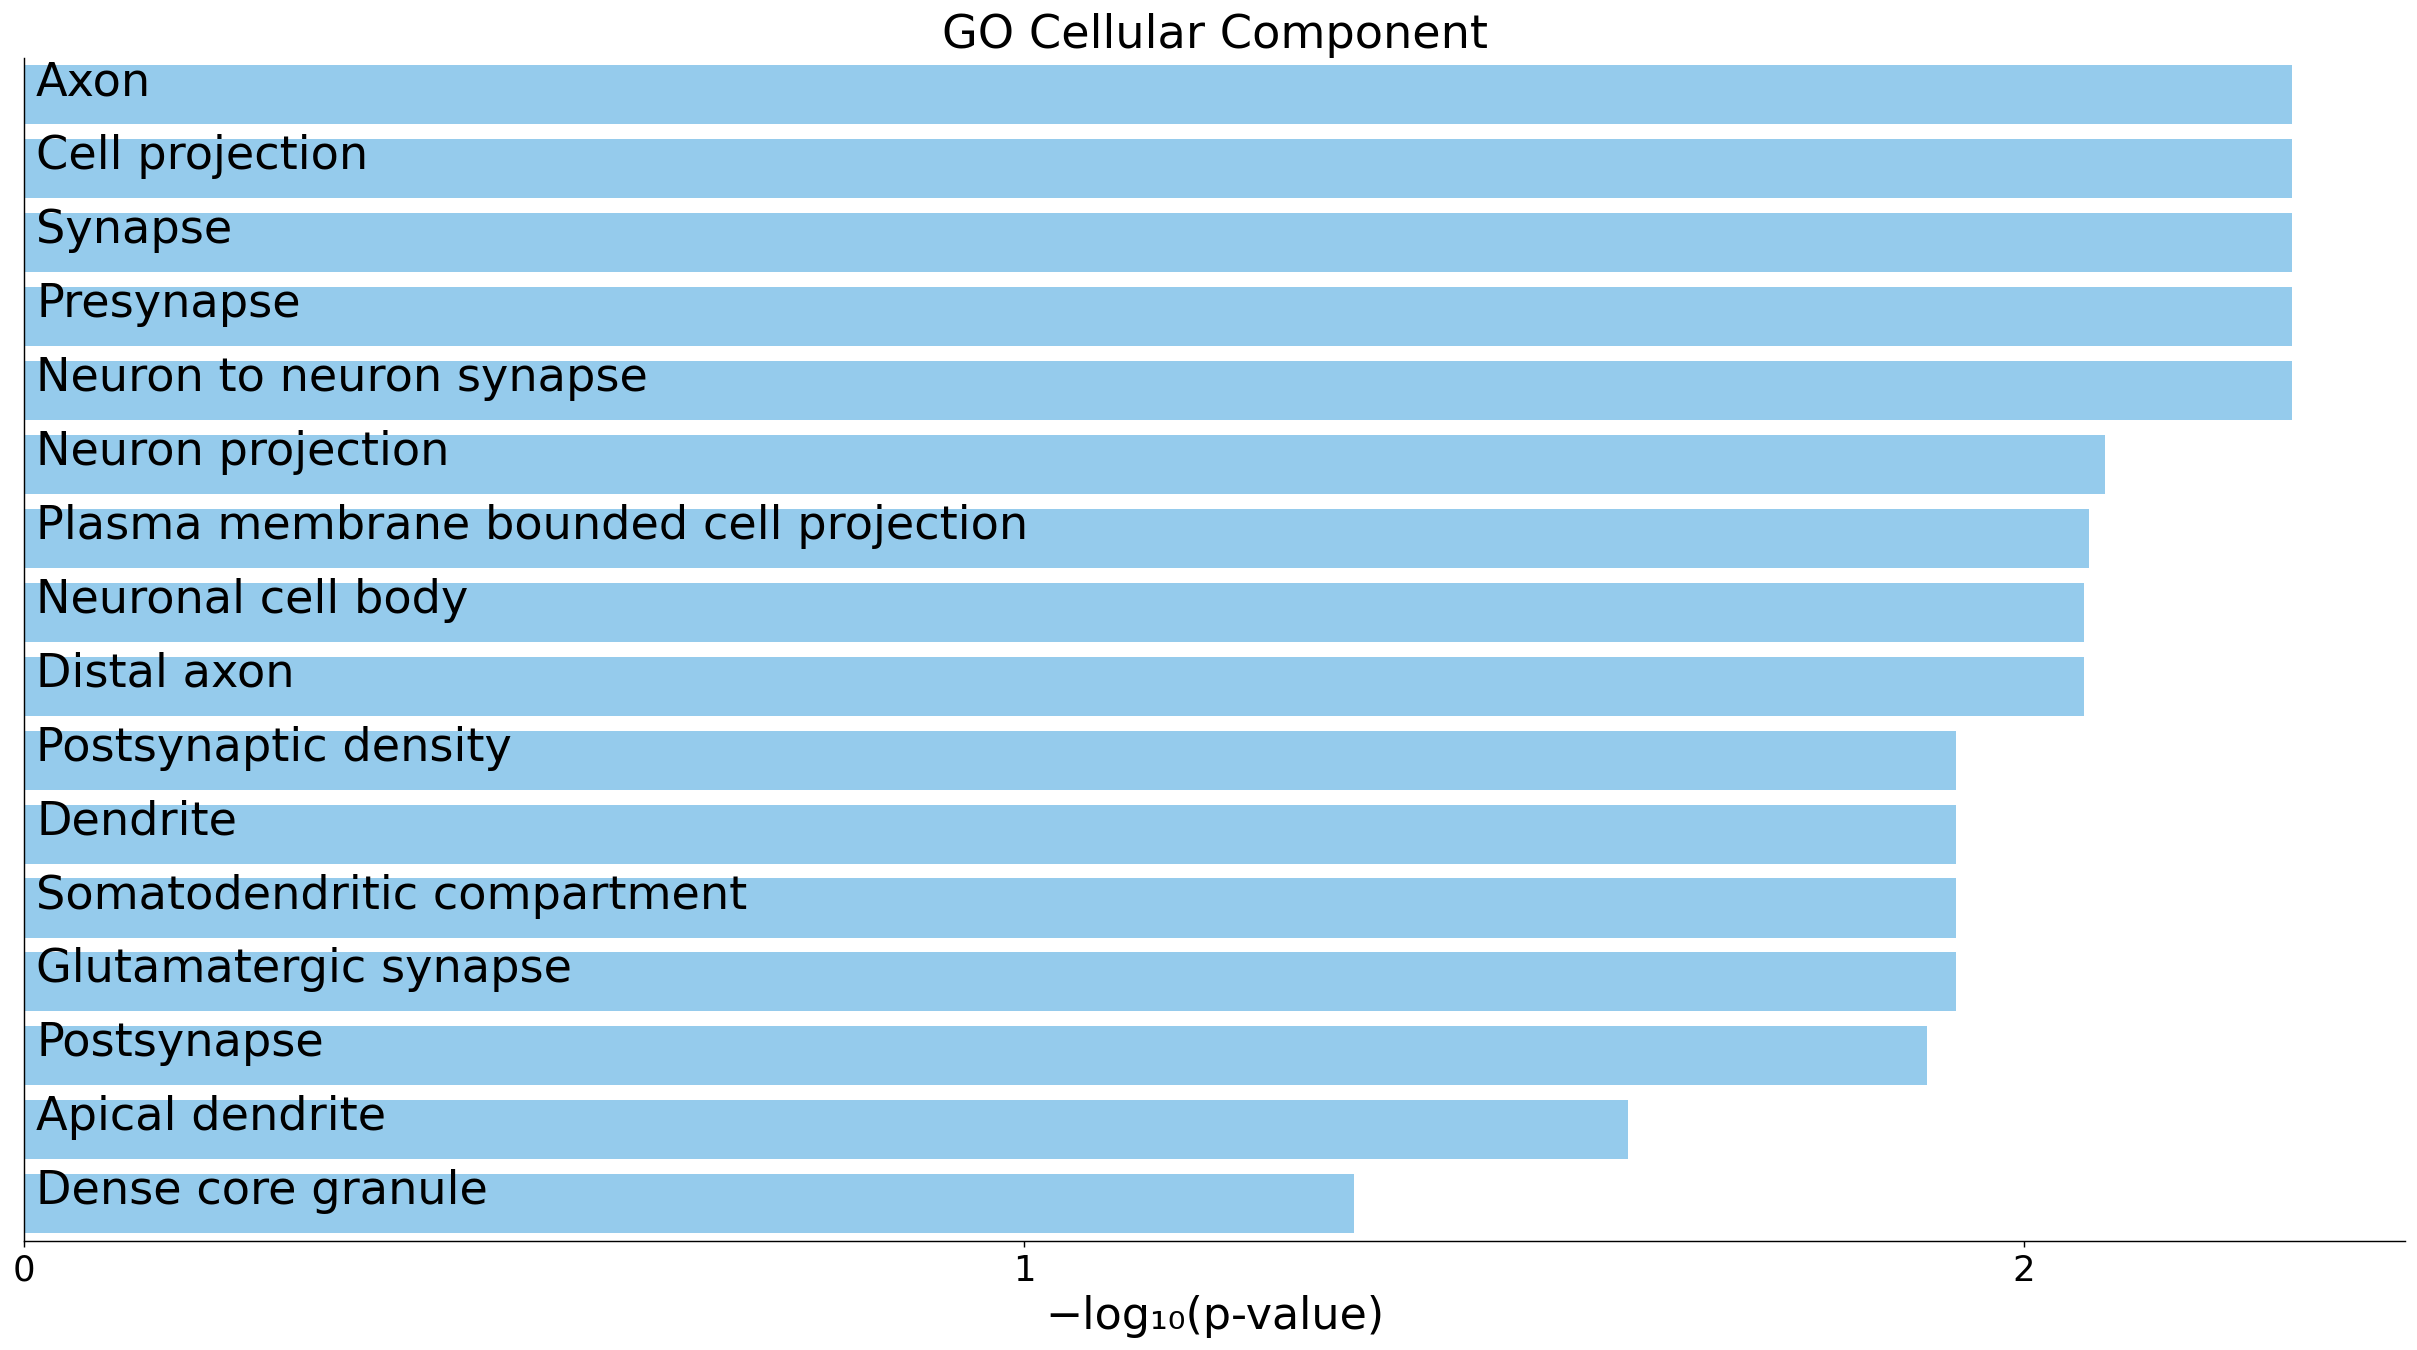

Enrichment Terms in ASTROCYTE


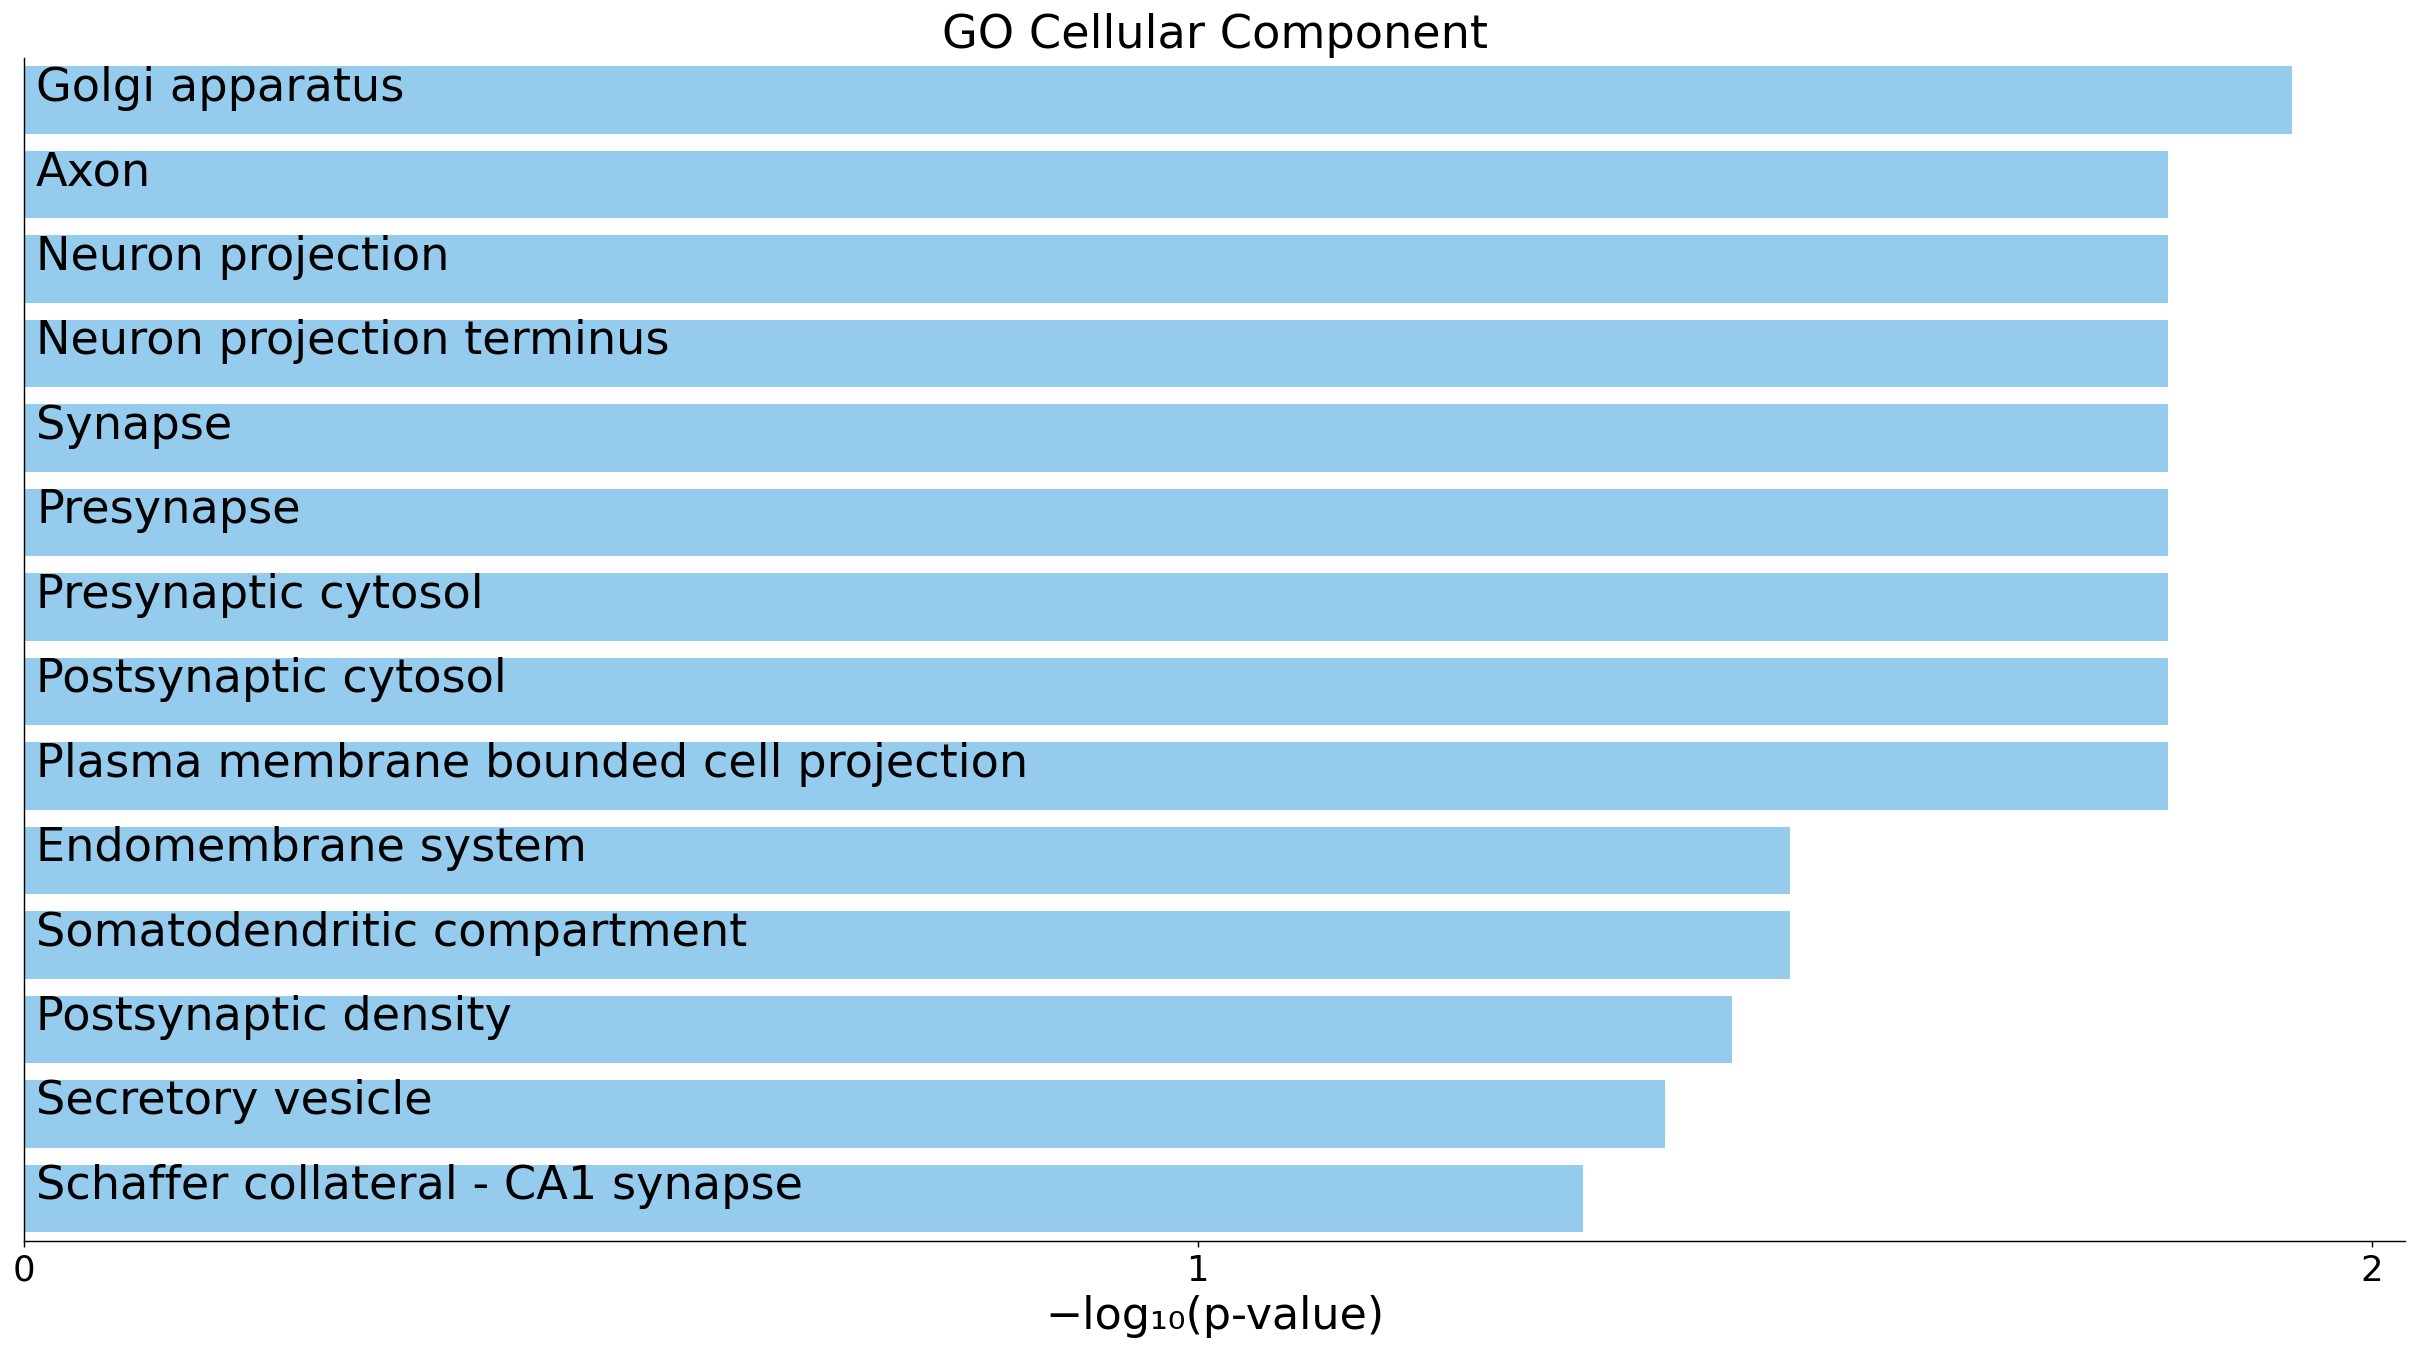

In [17]:
# import os
# figure_file_format = ['pdf', 'svg']
# color = 'lightskyblue'
# enrichr_library = 'GO Cellular Component'

# for test_name in ['ad_vs_no']:

#     for cell_type in ['Excitatory', 'Inhibitory', 'Astrocyte']:

#         print(f'Enrichment Terms in {cell_type.upper()}')

#         folder_path = f'../results/{test_name}/string/{cell_type}/'  # Replace with the actual folder path

#         files = os.listdir(folder_path)
#         matching_files = [file for file in files if file.startswith('enrichment.Component')]

#         for i, file in enumerate(matching_files):
#             data = pd.read_csv(f'../results/{test_name}/string/{cell_type}/{file}', sep='\t')
#             all_terms = data['term description'].to_list()
#             all_pvalues = data['false discovery rate'].astype(float).to_list()
#             all_adjusted_pvalues =  data['false discovery rate'].astype(float).to_list()
            
#             output_file_name = f'Enrichr_results_bar_{i}'
#             final_output_file_names = [f'../results/{test_name}/string/{cell_type}/{output_file_name}.{file_type}' for file_type in figure_file_format]
#             enrichment_figure(all_terms, all_pvalues, all_adjusted_pvalues, final_output_file_names, [enrichr_library], color)
